<a href="https://colab.research.google.com/github/mmbs1989/TCC-PUCMINAS/blob/main/Notebook_TCC_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL E DE VARIÁVEIS MACROECONÔMICAS UTILIZANDO SÉRIES TEMPORAIS<br>
<br>
ALUNO: Michel Muglia Barbosa Santos</h3>


In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 8.5MB/s 
     |████████████████████████████████| 9.5MB 26.9MB/s 
     |████████████████████████████████| 2.1MB 43.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [2]:
#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm
from pmdarima import auto_arima

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding
from keras.preprocessing.sequence import TimeseriesGenerator

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  




## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DA ARRECADAÇÃO FEDERAL**




In [ ]:
# Carregar os dados 
dfarrec = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfa = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcca.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfarrec['arrec'] = dfa['a']
dfarrec.head()

,Data,arrec
0,1994-01,4836
1,1994-02,4343
2,1994-03,4418
3,1994-04,5186
4,1994-05,4732


In [ ]:
dfarrec.tail()

,Data,arrec
315,2020-04,101154
316,2020-05,77415
317,2020-06,86258
318,2020-07,115990
319,2020-08,124505


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfarrec = dfarrec.drop(dfarrec.index[314:])
dfarrec.tail()

,Data,arrec
309,2019-10,135202
310,2019-11,125161
311,2019-12,147501
312,2020-01,174991
313,2020-02,116430


In [ ]:
# Transformar o tipo das colunas e definir o index
dfarrec['arrec'] = pd.to_numeric(dfarrec['arrec'])
dfarrec['Data'] = pd.to_datetime(dfarrec['Data'])
dfarrec.set_index('Data', inplace=True)

In [ ]:
dfarrec.head()

,arrec
Data,
1994-01-01,4836
1994-02-01,4343
1994-03-01,4418
1994-04-01,5186
1994-05-01,4732


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfarrec.describe().astype(int)

,arrec
count,314
mean,54008
std,42247
min,4343
25%,15014
50%,45332
75%,91308
max,174991


In [ ]:
# Confirmar se há valores nulos
dfarrec.isnull().sum()

arrec    0
dtype: int64

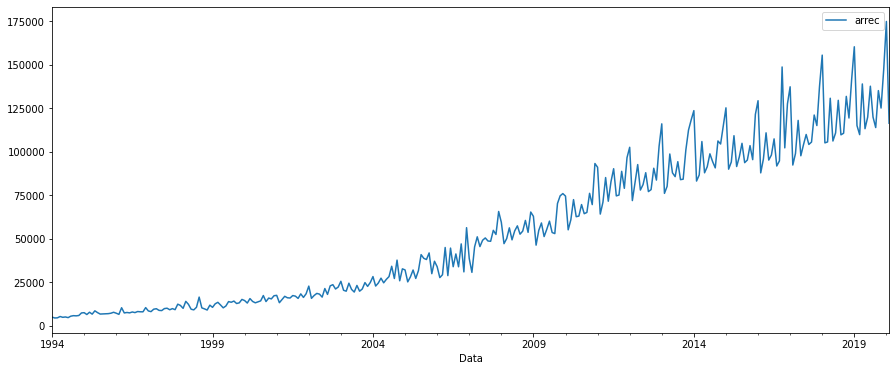

In [ ]:
# Gráfico dos valores
dfarrec.plot(figsize=(15,6))

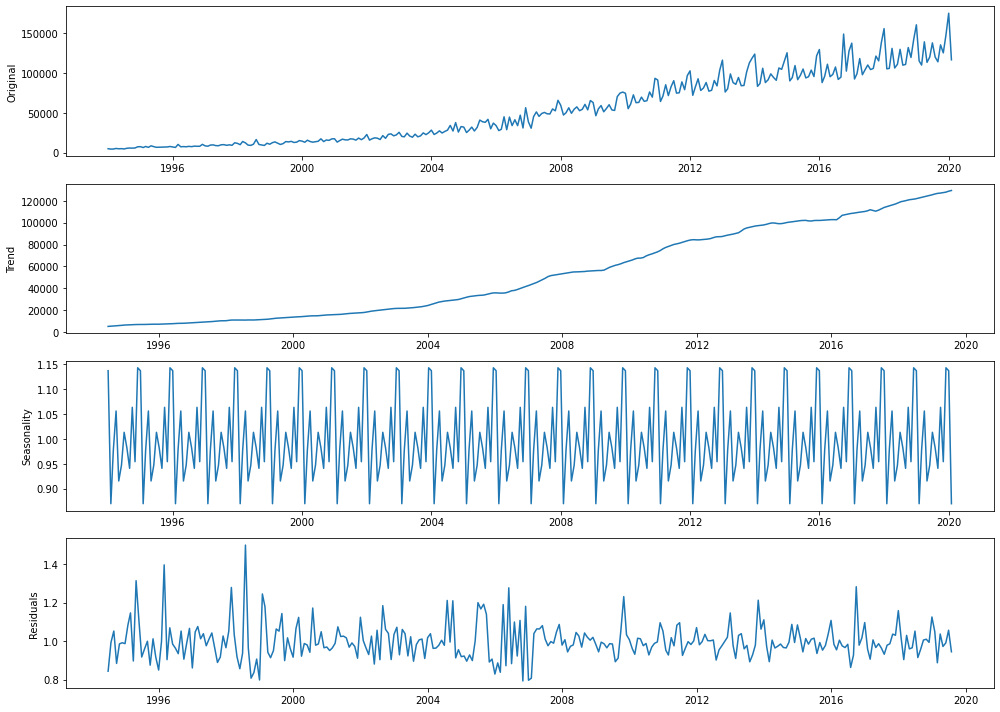

In [ ]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfarrec, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfarrec)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

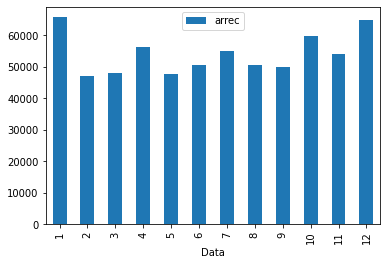

In [ ]:
# Análise dos períodos de sazonalidade
dfarrec.groupby(dfarrec.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DO PIB**




In [3]:
# Carregar os dados
dfpib = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccpib.csv")

In [5]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfpib['pib'] = dfp['pib']
dfpib.head()

,Data,pib
0,1994-01,4563
1,1994-02,5793
2,1994-03,8520
3,1994-04,12829
4,1994-05,20504


In [ ]:
dfpib.tail()

,Data,pib
315,2020-04,543554
316,2020-05,560059
317,2020-06,605147
318,2020-07,631041
319,2020-08,629988


In [6]:
# Retirar as linhas que não serão utilizadas na análise
dfpib = dfpib.drop(dfpib.index[314:])
dfpib.tail()

,Data,pib
309,2019-10,640907
310,2019-11,634654
311,2019-12,647460
312,2020-01,619785
313,2020-02,608644


In [7]:
# Transformar o tipo das colunas e definir o index
dfpib['pib'] = pd.to_numeric(dfpib['pib'])
dfpib['Data'] = pd.to_datetime(dfpib['Data'])
dfpib.set_index('Data', inplace=True)

In [ ]:
dfpib.head()

,pib
Data,
1994-01-01,4563
1994-02-01,5793
1994-03-01,8520
1994-04-01,12829
1994-05-01,20504


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfpib.describe().astype(int)

,pib
count,314
mean,269371
std,184225
min,4563
25%,101859
50%,216359
75%,448483
max,647460


In [ ]:
# Confirmar se há valores nulos
dfpib.isnull().sum()

pib    0
dtype: int64

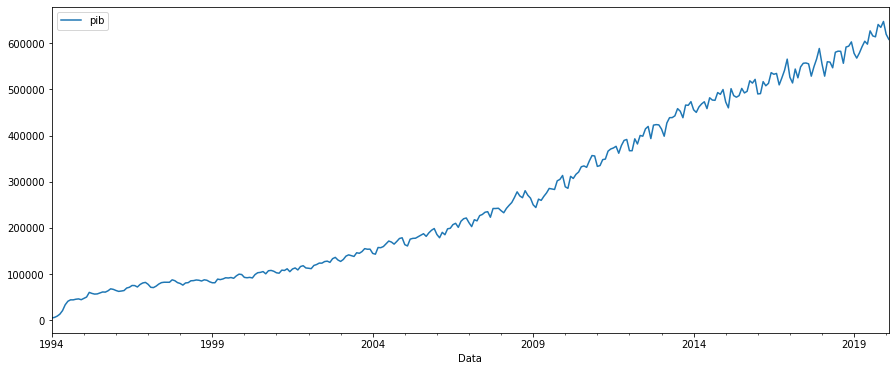

In [ ]:
# Gráfico dos valores
dfpib.plot(figsize=(15,6))

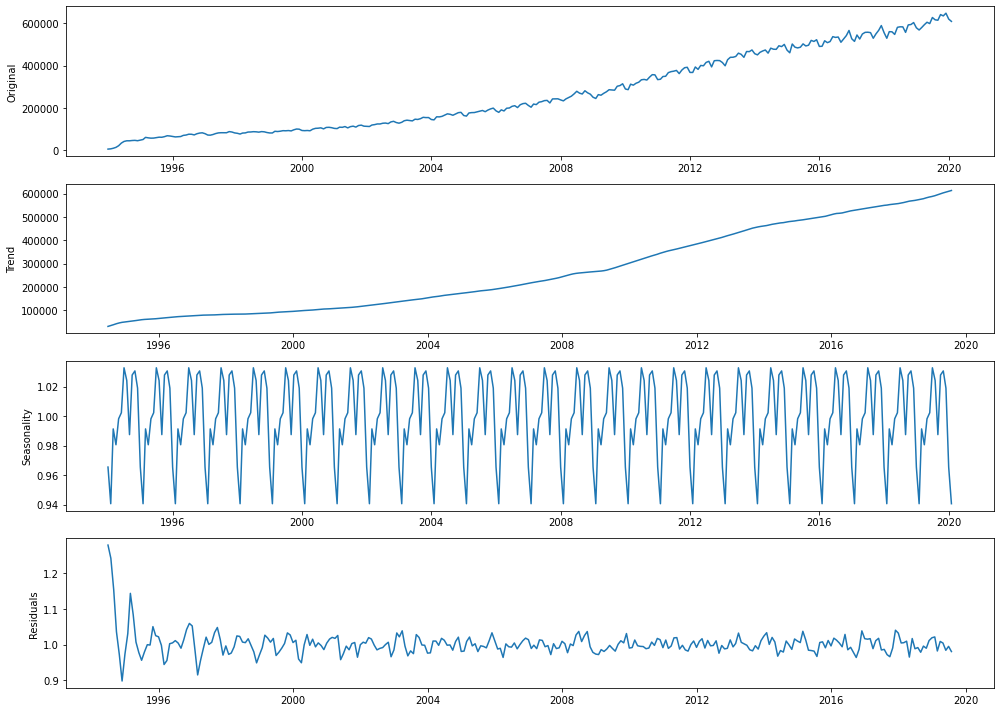

In [ ]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfpib, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfpib)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

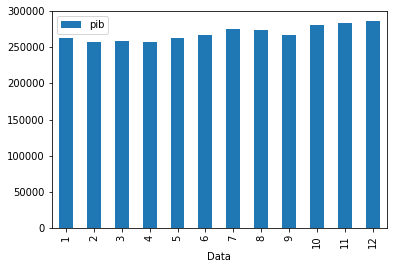

In [ ]:
# Análise dos períodos de sazonalidade
dfpib.groupby(dfpib.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS IMPORTAÇÕES**




In [ ]:
# Carregar os dados

dfimp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfi = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcci.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfimp['imp'] = dfi['i']
dfimp.head()

,Data,imp
0,1994-01,1768675231
1,1994-02,2030100974
2,1994-03,2248937491
3,1994-04,2151981505
4,1994-05,2624852192


In [ ]:
dfimp.tail()

,Data,imp
315,2020-04,11610871137
316,2020-05,13390915390
317,2020-06,10449294354
318,2020-07,11508172753
319,2020-08,11132508190


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfimp = dfimp.drop(dfimp.index[314:])
dfimp.tail()

,Data,imp
309,2019-10,17027283951
310,2019-11,14172102789
311,2019-12,12556086388
312,2020-01,16178224141
313,2020-02,13257290693


In [ ]:
# Transformar o tipo das colunas e definir o index
dfimp['imp'] = pd.to_numeric(dfimp['imp'])
dfimp['Data'] = pd.to_datetime(dfimp['Data'])
dfimp.set_index('Data', inplace=True)

In [ ]:
dfimp.head()

,imp
Data,
1994-01-01,1768675231
1994-02-01,2030100974
1994-03-01,2248937491
1994-04-01,2151981505
1994-05-01,2624852192


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfimp.describe().astype(int)

,imp
count,314
mean,9892422722
std,5810018770
min,1768675231
25%,4618010995
50%,8533476810
75%,14601529610
max,23049601170


In [ ]:
# Confirmar se há valores nulos
dfimp.isnull().sum()

imp    0
dtype: int64

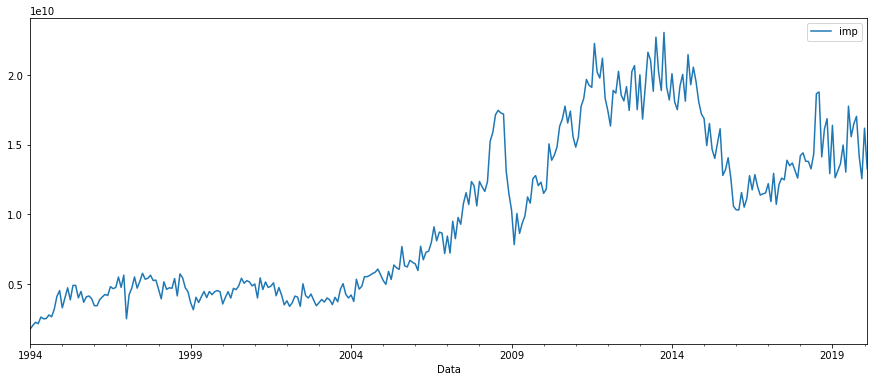

In [ ]:
# Gráfico dos valores
dfimp.plot(figsize=(15,6))

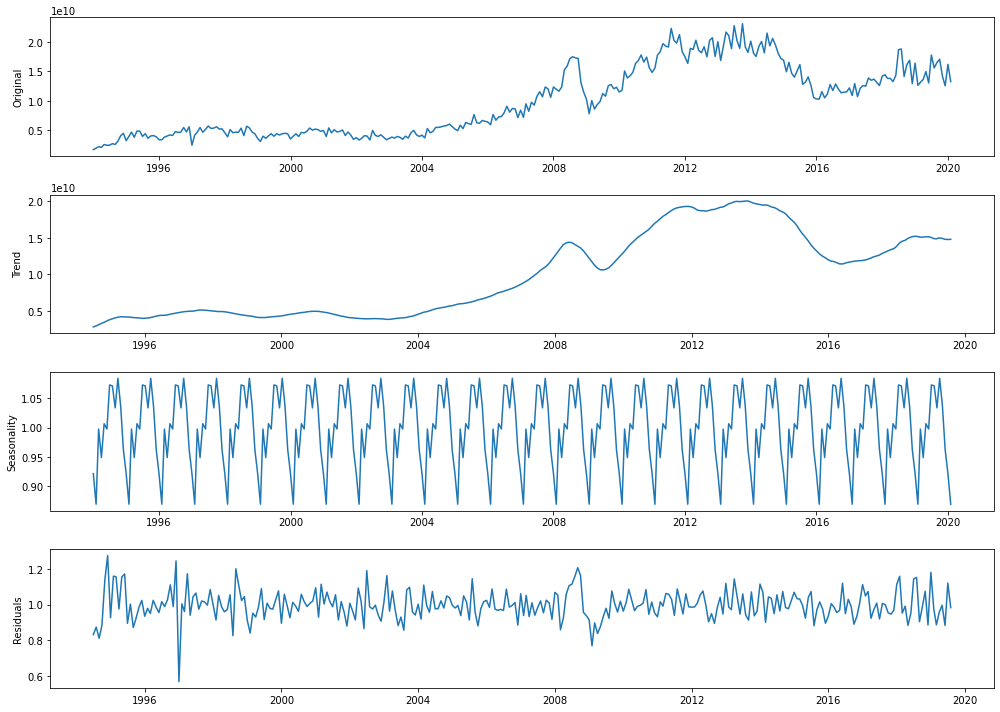

In [ ]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfimp, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfimp)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

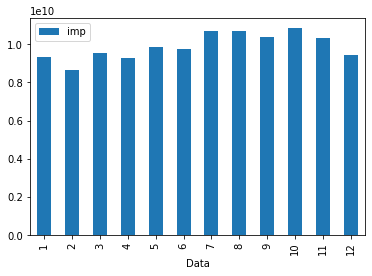

In [ ]:
# Análise dos períodos de sazonalidade
dfimp.groupby(dfimp.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS EXPORTAÇÕES**




In [ ]:
# Carregar os dados

dfexp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfe = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcce.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfexp['exp'] = dfe['e']
dfexp.head()

,Data,exp
0,1994-01,2747187653
1,1994-02,2778288879
2,1994-03,3350391558
3,1994-04,3634841763
4,1994-05,3862059965


In [ ]:
dfexp.tail()

,Data,exp
315,2020-04,17612476835
316,2020-05,17546386795
317,2020-06,17514983082
318,2020-07,19453592020
319,2020-08,17484221076


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfexp = dfexp.drop(dfexp.index[314:])
dfexp.tail()

,Data,exp
309,2019-10,19576839231
310,2019-11,17736715198
311,2019-12,18502977191
312,2020-01,14494583508
313,2020-02,15582390653


In [ ]:
# Transformar o tipo das colunas e definir o index
dfexp['exp'] = pd.to_numeric(dfexp['exp'])
dfexp['Data'] = pd.to_datetime(dfexp['Data'])
dfexp.set_index('Data', inplace=True)

In [ ]:
dfexp.head()

,exp
Data,
1994-01-01,2747187653
1994-02-01,2778288879
1994-03-01,3350391558
1994-04-01,3634841763
1994-05-01,3862059965


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfexp.describe().astype(int)

,exp
count,314
mean,11642469810
std,6617465613
min,2747187653
25%,4632933982
50%,11846627371
75%,17681900227
max,26148242211


In [ ]:
# Confirmar se há valores nulos
dfexp.isnull().sum()

exp    0
dtype: int64

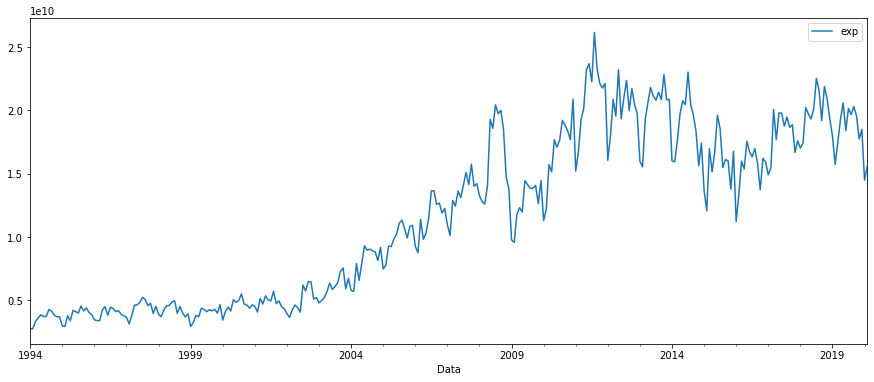

In [ ]:
# Gráfico dos valores
dfexp.plot(figsize=(15,6))

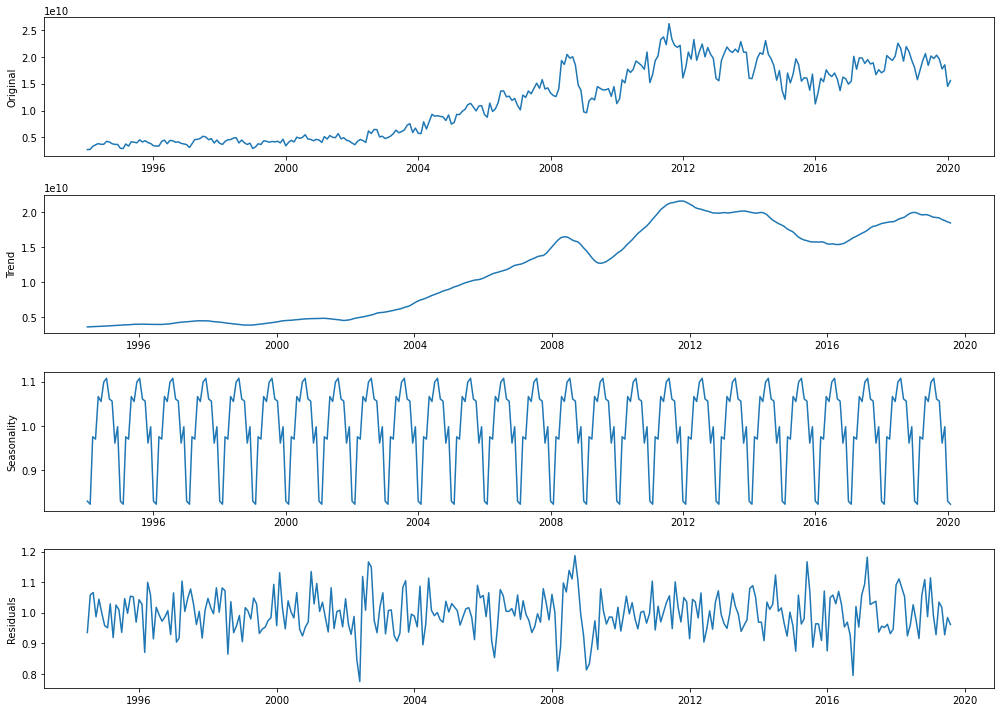

In [ ]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfexp, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfexp)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

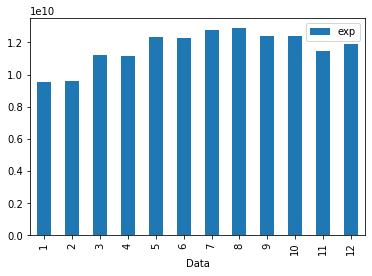

In [ ]:
# Análise dos períodos de sazonalidade
dfexp.groupby(dfexp.index.month).mean().plot(kind='bar')

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_arima = dfarrec.iloc[:-14].copy()  
dfarrec_test_arima =  dfarrec.iloc[-14:].copy()
dfarrec_test_arima.head()

,arrec
Data,
2019-01-01,160426
2019-02-01,115062
2019-03-01,109854
2019-04-01,139030
2019-05-01,113278


In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modeloARIMAARREC = auto_arima(dfarrec_train_arima['arrec'], test='adf', trace=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6435.374, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6087.001, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6239.498, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6433.862, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6389.975, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6069.247, Time=1.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6284.242, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=6036.571, Time=3.55 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.66 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=6043.259, Time=3.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=6114.465, Time=3.15 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=6045.667, Time=5.35 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept

In [ ]:
print(modeloARIMAARREC.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2973.555
Date:                            Wed, 17 Mar 2021   AIC                           5959.110
Time:                                    00:31:22   BIC                           5981.312
Sample:                                         0   HQIC                          5967.996
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0668      0.054      1.242      0.214      -0.039       0.172
ar.L2          0.0437      0.072   

In [ ]:
# Treinamento do modelo
modeloARIMAARREC.fit(dfarrec_train_arima['arrec'])

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_ARIMAARREC = modeloARIMAARREC.predict(n_periods=len(dfarrec_test_arima['arrec']))
forecast_ARIMAARREC = pd.DataFrame(forecast_ARIMAARREC, index = dfarrec_test_arima.index,columns=['Prediction'])
conf_int = modeloARIMAARREC.predict(len(dfarrec_test_arima['arrec']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

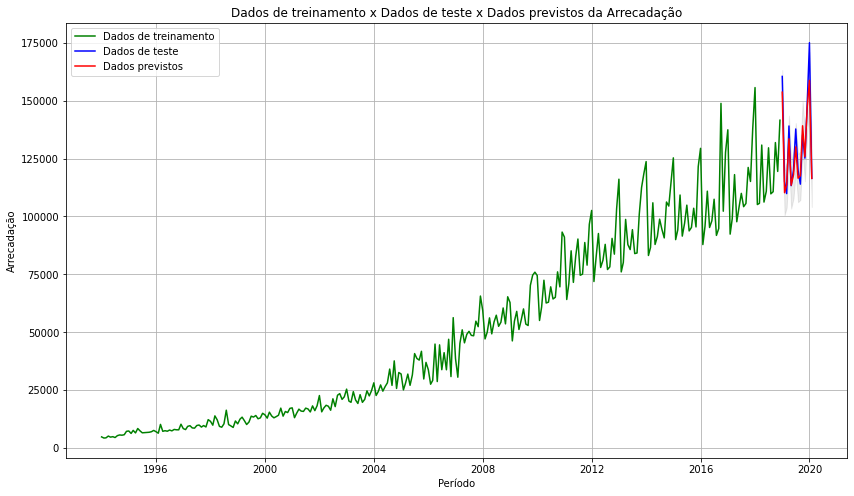

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_train_arima['arrec'], color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_ARIMAARREC['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

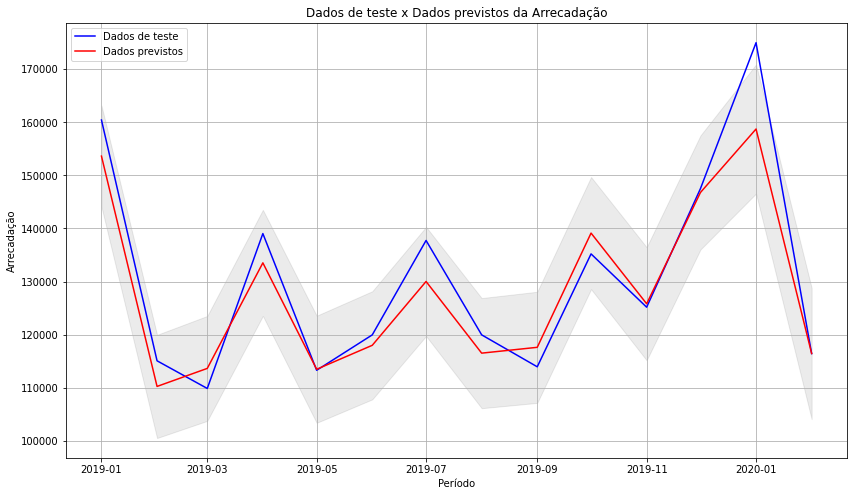

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_ARIMAARREC['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAARREC = int(mean_absolute_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction']))
MSEARIMAARREC = int(mean_squared_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction']))
RMSEARIMAARREC = int(math.sqrt(mean_squared_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction'])))

print('MSE: '+str(MSEARIMAARREC))
print('MAE: '+str(MAEARIMAARREC))
print('RMSE: '+str(RMSEARIMAARREC))

MSE: 34573565
MAE: 4248
RMSE: 5879


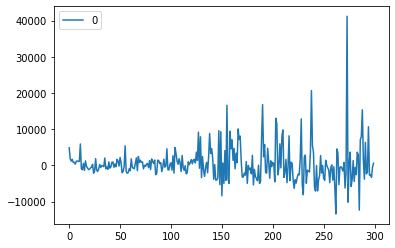

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(modeloARIMAARREC.resid())
residuals.plot()

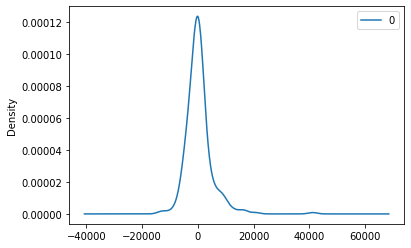

                  0
count    300.000000
mean     384.606592
std     4870.195929
min   -13429.432156
25%    -2021.885744
50%     -182.383249
75%     1600.780196
max    41177.794807


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
288/288 [==============================] - 6s 16ms/step - loss: 0.0343
Epoch 2/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0087
Epoch 3/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0036
Epoch 4/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0055
Epoch 5/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0048
Epoch 6/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0053
Epoch 7/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0050
Epoch 8/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0031
Epoch 9/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0040
Epoch 10/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0045
Epoch 11/300
288/288 [==============================] - 5s 17ms/step - loss: 0.0034
Epoch 12/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0027
E

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

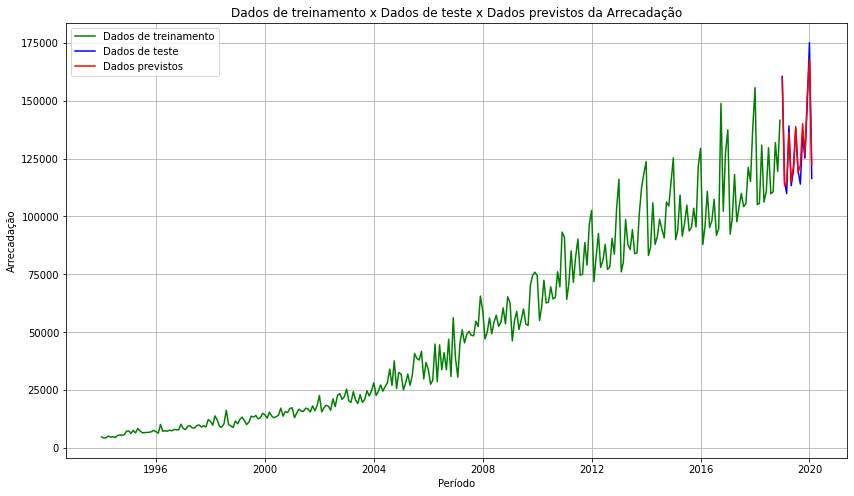

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

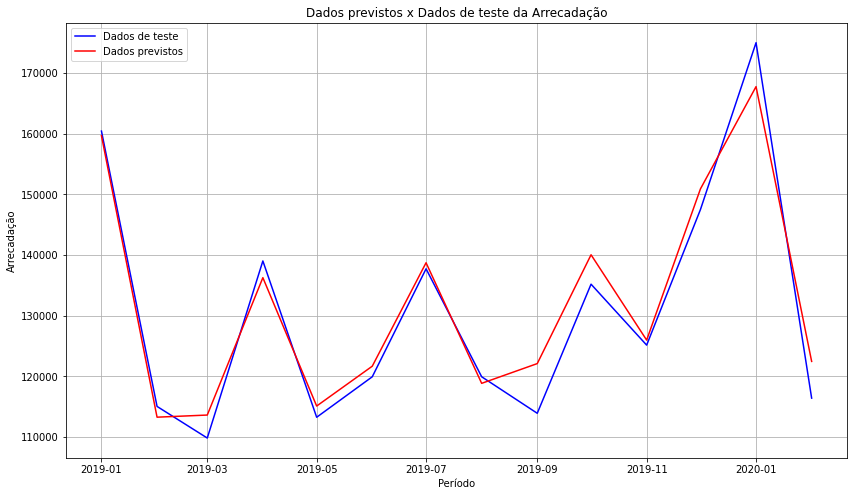

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMARREC = int(mean_absolute_error(dfarrec_test_lstm,lstm_predictions))
MSELSTMARREC = int(mean_squared_error(dfarrec_test_lstm,lstm_predictions))
RMSELSTMARREC = int(np.sqrt(mean_squared_error(dfarrec_test_lstm,lstm_predictions)))

print('MSE: '+str(MSELSTMARREC))
print('MAE: '+str(MAELSTMARREC))
print('RMSE: '+str(RMSELSTMARREC))

MSE: 16145662
MAE: 3235
RMSE: 4018


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_prophet = dfarrec.iloc[:-14].copy()  
dfarrec_test_prophet =  dfarrec.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfarrec_train_prophet = pd.DataFrame({"ds": dfarrec_train_prophet.index, "y": dfarrec_train_prophet.arrec})
dfarrec_train_prophet.reset_index(drop = True, inplace = True)
dfarrec_test_prophet = pd.DataFrame({"ds_test": dfarrec_test_prophet.index, "y_test": dfarrec_test_prophet.arrec})
dfarrec_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfarrec_test_prophet.head()

,ds_test,y_test
0,2019-01-01,160426
1,2019-02-01,115062
2,2019-03-01,109854
3,2019-04-01,139030
4,2019-05-01,113278


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet()
prophet_model.fit(dfarrec_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(41.125, 0.5, 'Arrecadação')

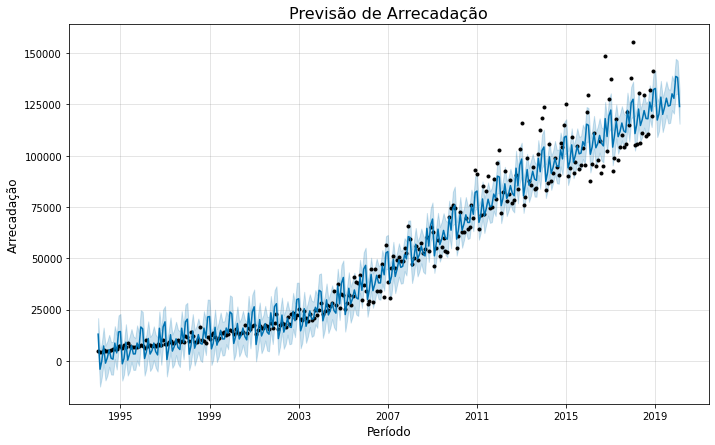

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de Arrecadação", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Arrecadação", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,124356.240643,124801.923651,141491.497907,124356.240643,124356.240643,8478.847872,8478.847872,8478.847872,8478.847872,8478.847872,8478.847872,0.0,0.0,0.0,132835.088516
301,2019-02-01,124850.303486,109104.834450,126349.295056,124850.303486,124850.303486,-7454.965244,-7454.965244,-7454.965244,-7454.965244,-7454.965244,-7454.965244,0.0,0.0,0.0,117395.338242
302,2019-03-01,125296.553796,111912.057459,128391.167962,125294.372278,125302.957816,-4934.730676,-4934.730676,-4934.730676,-4934.730676,-4934.730676,-4934.730676,0.0,0.0,0.0,120361.823119
303,2019-04-01,125790.616638,120259.448244,136507.473893,125776.658311,125809.589962,2787.469141,2787.469141,2787.469141,2787.469141,2787.469141,2787.469141,0.0,0.0,0.0,128578.085779
304,2019-05-01,126268.741970,111512.399863,128325.843262,126240.130226,126302.820972,-6115.813858,-6115.813858,-6115.813858,-6115.813858,-6115.813858,-6115.813858,0.0,0.0,0.0,120152.928112


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfarrec_test_prophet.set_index(dfarrec_test_prophet['ds_test'], inplace=True) 
dfarrec_train_prophet.set_index(dfarrec_train_prophet['ds'], inplace=True) 

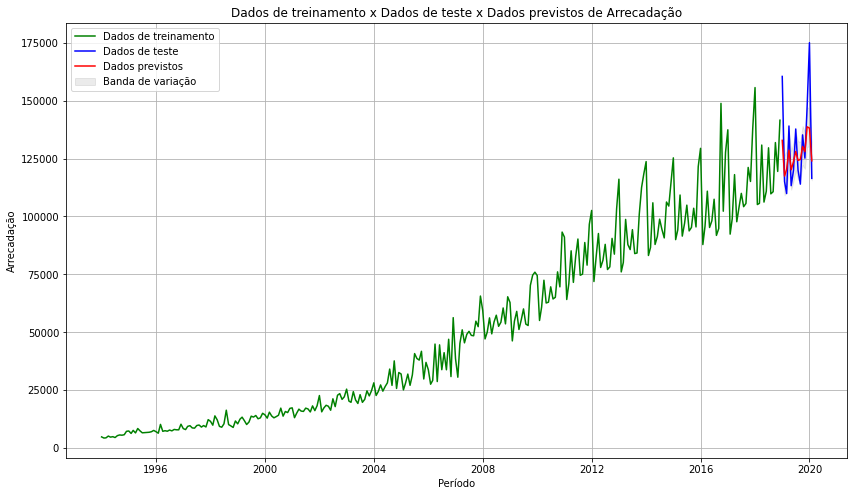

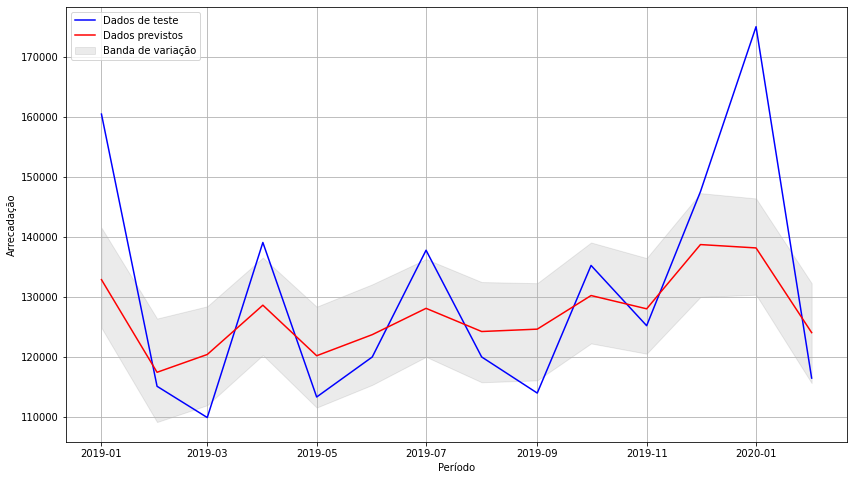

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfarrec_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos de Arrecadação')
plt.plot(dfarrec_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)

#Plotagem do comparativo entre os valores originais com os previstos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETARREC =  int(mean_absolute_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETARREC = int(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETARREC = int(np.sqrt(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat'])))

print('MSE: '+str(MSEPROPHETARREC))
print('MAE: '+str(MAEPROPHETARREC))
print('RMSE: '+str(RMSEPROPHETARREC))

MSE: 200026457
MAE: 10510
RMSE: 14143


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfarrec_comparativo = dfarrec_test_arima.copy()
dfarrec_comparativo['PREVISÃO_ARIMA'] = forecast_ARIMAARREC['Prediction']
dfarrec_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfarrec_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfarrec_comparativo.head(14)

,arrec,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,160426,153621.014229,132835.088516,159669.793979
2019-02-01,115062,110234.837646,117395.338242,113289.577076
2019-03-01,109854,113630.404791,120361.823119,113640.509073
2019-04-01,139030,133512.974041,128578.085779,136275.631916
2019-05-01,113278,113467.029556,120152.928112,115124.450090
2019-06-01,119946,117982.344141,123669.021680,121690.349889
2019-07-01,137735,130008.420615,128052.490465,138733.959247
2019-08-01,119951,116505.884958,124190.784839,118865.329278
2019-09-01,113933,117603.079125,124583.851815,122119.078425


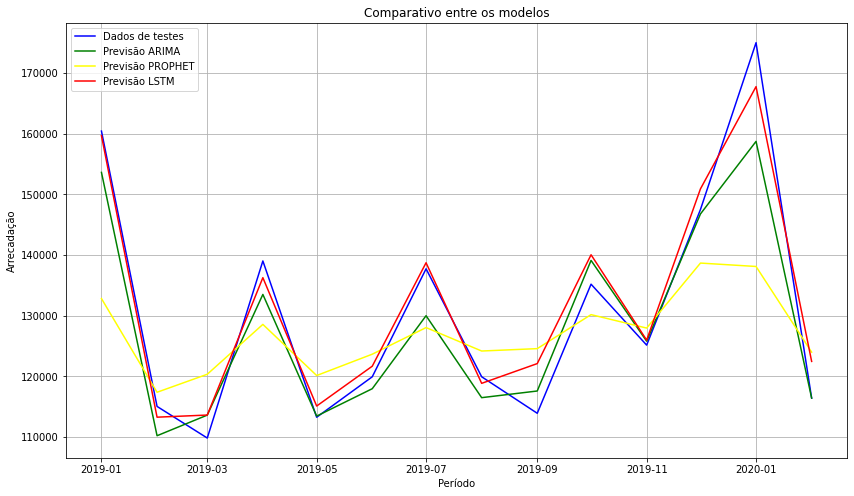

In [ ]:
# Plotagem do comparativo entre os modelos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["arrec"], color='blue', label = 'Dados de testes')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_ARIMA"], color = 'green', label = 'Previsão ARIMA')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_PROPHET"], color = 'yellow', label = 'Previsão PROPHET')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_LSTM"], color = 'red', label = 'Previsão LSTM')
plt.title('Comparativo entre os modelos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
#Comparativo dos erros
dfarrec_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfarrec_erro['MAE'] = [MAEARIMAARREC, MAELSTMARREC, MAEPROPHETARREC]
dfarrec_erro['MSE'] = [MSEARIMAARREC, MSELSTMARREC, MSEPROPHETARREC]
dfarrec_erro['RMSE'] = [RMSEARIMAARREC, RMSELSTMARREC, RMSEPROPHETARREC]
dfarrec_erro = dfarrec_erro.sort_values('MAE')
dfarrec_erro.set_index('Modelos', inplace=True)
dfarrec_erro.head()

,MAE,MSE,RMSE
Modelos,,,
LSTM,3235,16145662,4018
ARIMA,4248,34573565,5879
Prophet,10510,200026457,14143


## **MODELOS PREDITIVOS DO PIB**







## Modelo preditivo ARIMA

In [8]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_arima = dfpib.iloc[:-14].copy()  
dfpib_test_arima =  dfpib.iloc[-14:].copy()

In [9]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modelARIMAPIB = auto_arima(dfpib_train_arima['pib'], test='adf', trace=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6236.065, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6421.949, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6165.243, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6279.806, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6429.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6408.128, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6257.408, Time=0.64 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6259.239, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6295.808, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6199.300, Time=0.57 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=6148.609, Time=1.00 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=6378.532, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=6238.716, Time=0.91 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [10]:
print(modelARIMAPIB.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -3069.304
Date:                            Thu, 18 Mar 2021   AIC                           6148.609
Time:                                    00:19:22   BIC                           6167.111
Sample:                                         0   HQIC                          6156.014
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1602.7314    377.179      4.249      0.000     863.474    2341.989
ar.L1         -0.4427      0.037   

In [11]:
# Treinamento do modelo
modelARIMAPIB.fit(dfpib_train_arima['pib'])

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [12]:
#Faz a predição 
forecast_arima = modelARIMAPIB.predict(n_periods=len(dfpib_test_arima['pib']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfpib_test_arima.index,columns=['Prediction'])
conf_int = modelARIMAPIB.predict(len(dfpib_test_arima['pib']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

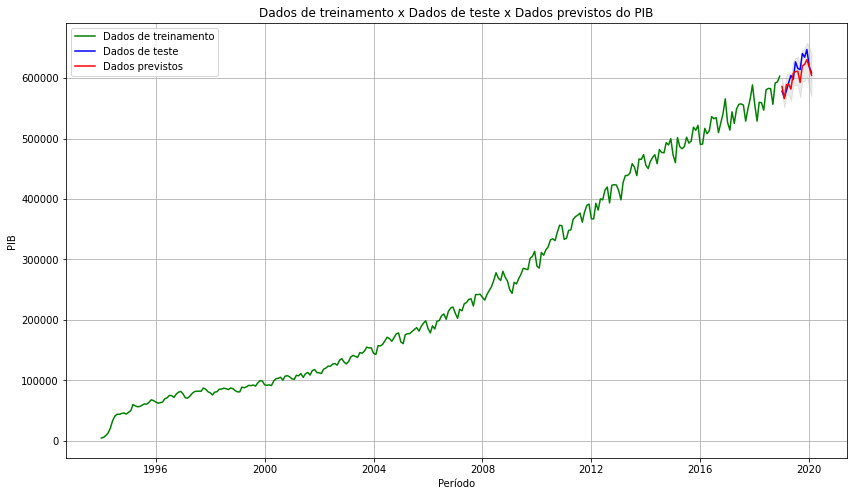

In [13]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_arima['pib'], color='green', label = 'Dados de treinamento')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
plt.show()

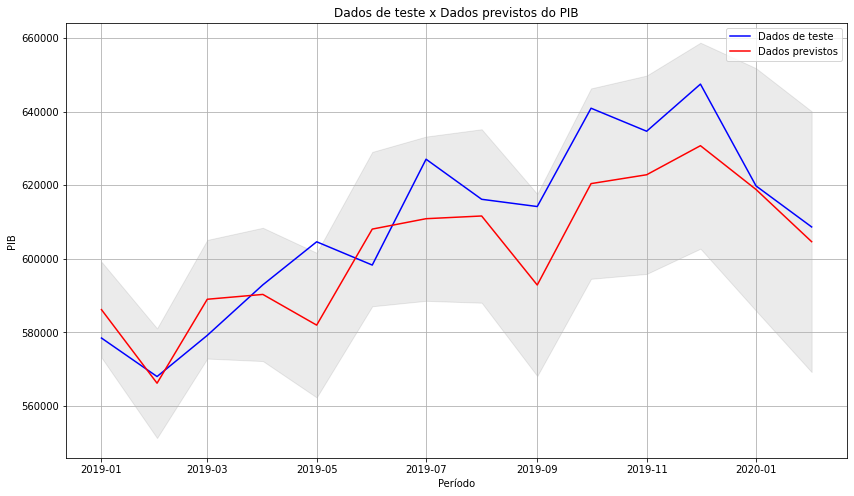

In [14]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#Cálculo do erro
MAEARIMAPIB = int(mean_absolute_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
MSEARIMAPIB = int(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
RMSEARIMAPIB = int(math.sqrt(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])))


print('MSE: '+str(MSEARIMAPIB))
print('MAE: '+str(MAEARIMAPIB))
print('RMSE: '+str(RMSEARIMAPIB))

MSE: 169126237
MAE: 10744
RMSE: 13004


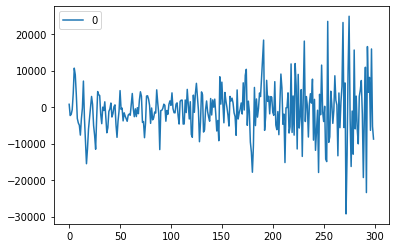

In [16]:
#Plotagem dos resíduos
residuals = pd.DataFrame(modelARIMAPIB.resid())
residuals.plot()

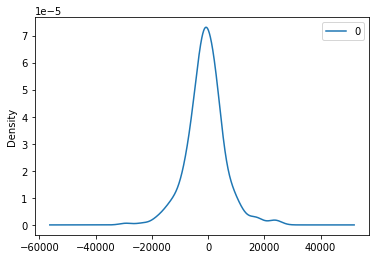

                  0
count    300.000000
mean    -852.672933
std     6828.185400
min   -29266.096407
25%    -4324.909127
50%     -941.528741
75%     2865.236184
max    24867.346500


In [17]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [18]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_lstm = dfpib.iloc[:-14].copy()  
dfpib_test_lstm =  dfpib.iloc[-14:].copy()

In [19]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfpib_train_lstm.iloc[:,0:1].values
test_lstm = dfpib_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [20]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [21]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
288/288 [==============================] - 6s 15ms/step - loss: 0.0223
Epoch 2/300
288/288 [==============================] - 4s 15ms/step - loss: 0.0010
Epoch 3/300
288/288 [==============================] - 4s 16ms/step - loss: 9.9020e-04
Epoch 4/300
288/288 [==============================] - 4s 15ms/step - loss: 0.0011
Epoch 5/300
288/288 [==============================] - 5s 16ms/step - loss: 0.0014
Epoch 6/300
288/288 [==============================] - 4s 15ms/step - loss: 8.4378e-04
Epoch 7/300
288/288 [==============================] - 4s 16ms/step - loss: 0.0020
Epoch 8/300
288/288 [==============================] - 4s 15ms/step - loss: 7.6921e-04
Epoch 9/300
288/288 [==============================] - 4s 15ms/step - loss: 7.2440e-04
Epoch 10/300
288/288 [==============================] - 4s 15ms/step - loss: 6.7013e-04
Epoch 11/300
288/288 [==============================] - 4s 15ms/step - loss: 8.5706e-04
Epoch 12/300
288/288 [==============================] - 4s 15

In [23]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [24]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

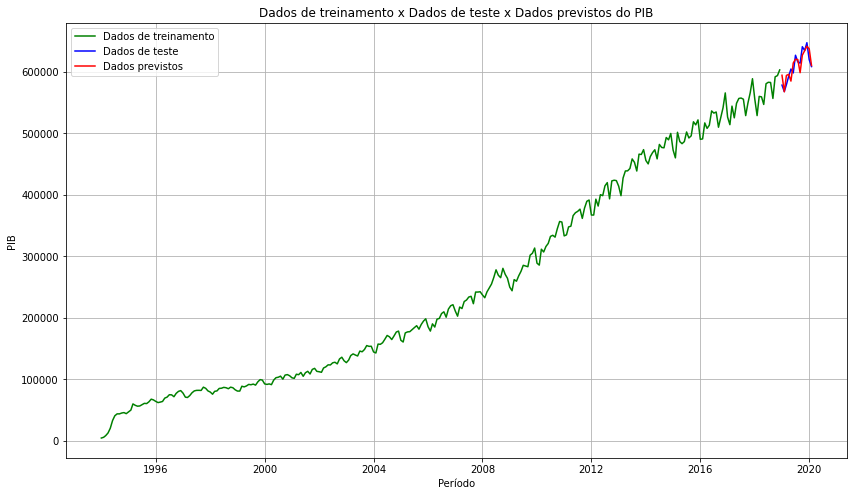

In [25]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.plot(dfpib_train_lstm.index, dfpib_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfpib_test_lstm.index, dfpib_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfpib_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
plt.show()

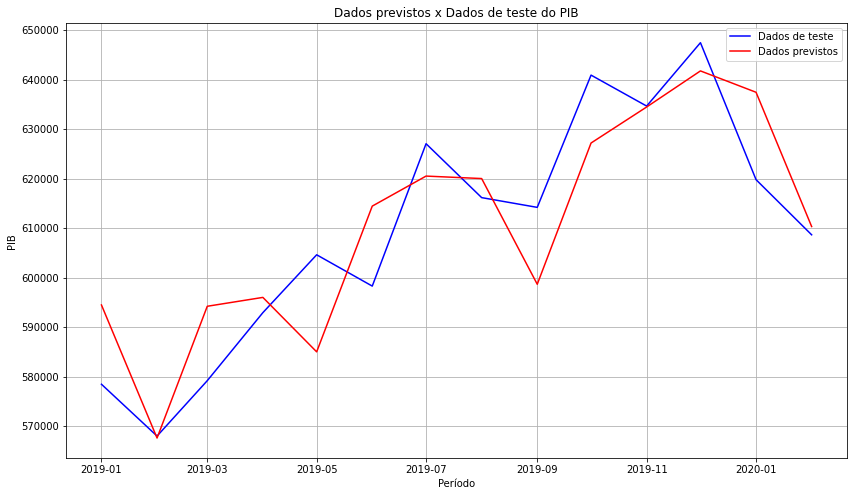

In [27]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(14,8))
plt.plot(dfpib_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfpib_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste do PIB')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#Cálculo do erro
MAELSTMPIB = int(mean_absolute_error(dfpib_test_lstm,lstm_predictions))
MSELSTMPIB = int(mean_squared_error(dfpib_test_lstm,lstm_predictions))
RMSELSTMPIB = int(np.sqrt(mean_squared_error(dfpib_test_lstm,lstm_predictions)))


print('MSE: '+str(MSELSTMPIB))
print('MAE: '+str(MAELSTMPIB))
print('RMSE: '+str(RMSELSTMPIB))

MSE: 140868984
MAE: 9654
RMSE: 11868


## Modelo Preditivo PROPHET

In [29]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_prophet = dfpib.iloc[:-14].copy()  
dfpib_test_prophet =  dfpib.iloc[-14:].copy()

In [30]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfpib_train_prophet = pd.DataFrame({"ds": dfpib_train_prophet.index, "y": dfpib_train_prophet.pib})
dfpib_train_prophet.reset_index(drop = True, inplace = True)
dfpib_test_prophet = pd.DataFrame({"ds_test": dfpib_test_prophet.index, "y_test": dfpib_test_prophet.pib})
dfpib_test_prophet.reset_index(drop = True, inplace = True)

In [31]:
dfpib_train_prophet.head()

,ds,y
0,1994-01-01,4563
1,1994-02-01,5793
2,1994-03-01,8520
3,1994-04-01,12829
4,1994-05-01,20504


In [32]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet()
prophet_model.fit(dfpib_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(41.375, 0.5, 'PIB')

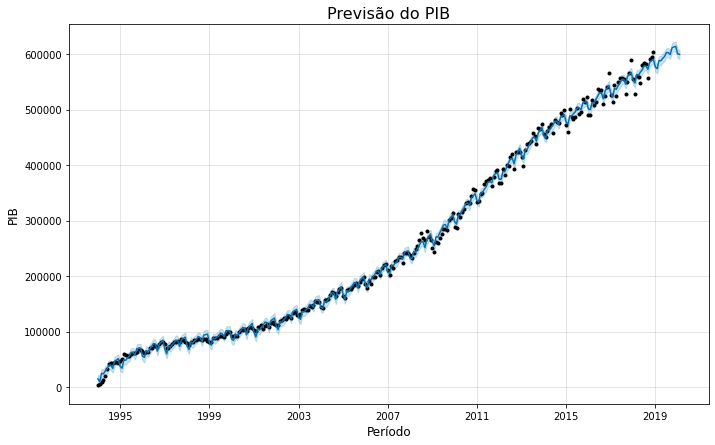

In [33]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão do PIB", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("PIB", fontsize=12)

In [34]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,585628.418285,568134.911584,585130.628428,585628.418285,585628.418285,-8855.620867,-8855.620867,-8855.620867,-8855.620867,-8855.620867,-8855.620867,0.0,0.0,0.0,576772.797418
301,2019-02-01,587739.767215,565165.713240,582192.040556,587739.767215,587739.767215,-14103.097244,-14103.097244,-14103.097244,-14103.097244,-14103.097244,-14103.097244,0.0,0.0,0.0,573636.669971
302,2019-03-01,589646.792055,579676.009600,596744.887703,589613.029878,589650.823413,-1355.916698,-1355.916698,-1355.916698,-1355.916698,-1355.916698,-1355.916698,0.0,0.0,0.0,588290.875358
303,2019-04-01,591758.140985,579833.998375,596150.470516,591629.075793,591836.006217,-3869.875112,-3869.875112,-3869.875112,-3869.875112,-3869.875112,-3869.875112,0.0,0.0,0.0,587888.265874
304,2019-05-01,593801.381886,584021.694400,601190.662745,593542.266757,593978.978876,-1500.576474,-1500.576474,-1500.576474,-1500.576474,-1500.576474,-1500.576474,0.0,0.0,0.0,592300.805411


In [35]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfpib_test_prophet.set_index(dfpib_test_prophet['ds_test'], inplace=True) 
dfpib_train_prophet.set_index(dfpib_train_prophet['ds'], inplace=True) 

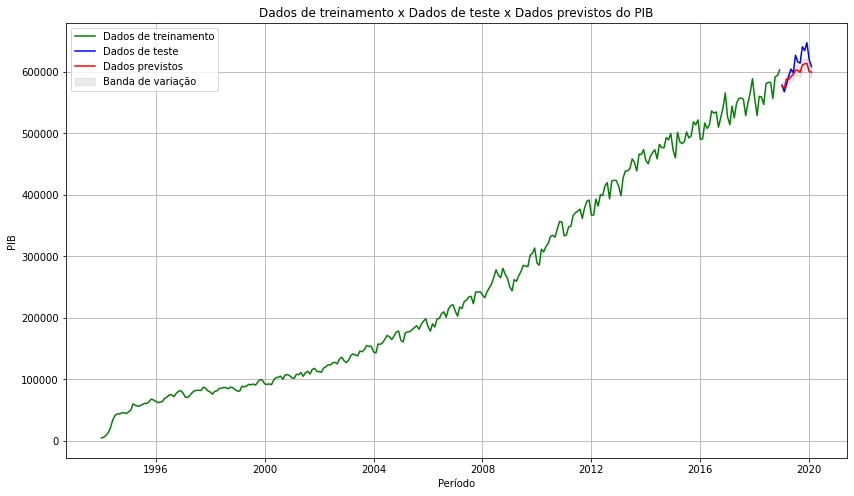

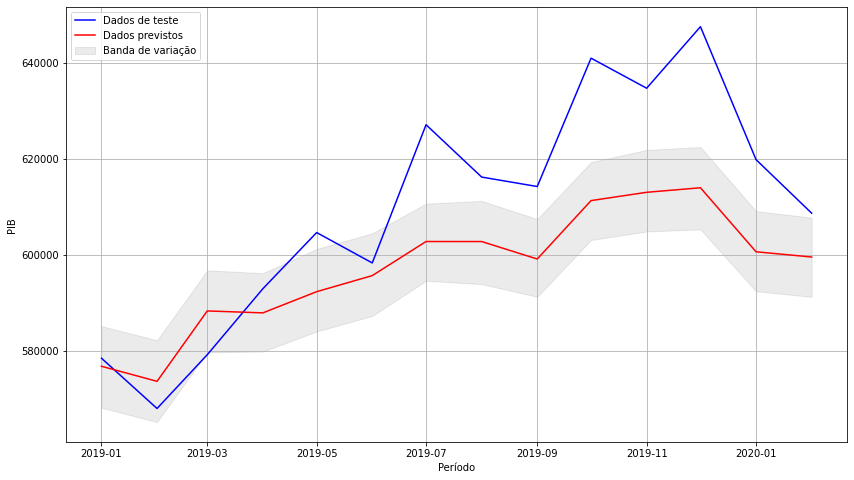

In [36]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfpib_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
#Cálculo do erro
MAEPROPHETPIB = int(mean_absolute_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETPIB = int(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETPIB = int(np.sqrt(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat'])))

print('MSE: '+str(MSEPROPHETPIB))
print('MAE: '+str(MAEPROPHETPIB))
print('RMSE: '+str(RMSEPROPHETPIB))

MSE: 301714278
MAE: 14456
RMSE: 17369


## Comparativo entre os modelos

In [38]:
#Criar dataframe de comparação entre os modelos
dfpib_comparativo = dfpib_test_arima.copy()
dfpib_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfpib_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfpib_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfpib_comparativo.head(14)

,pib,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,578453,586173.317181,576772.797418,594470.122398
2019-02-01,567985,566177.926019,573636.669971,567585.884659
2019-03-01,579173,588991.643749,588290.875358,594206.170166
2019-04-01,592916,590304.647067,587888.265874,595997.677261
2019-05-01,604607,581960.695311,592300.805411,584997.740921
2019-06-01,598283,608057.425873,595646.863223,614443.078842
2019-07-01,627050,610883.433455,602741.567051,620508.699715
2019-08-01,616158,611620.098056,602736.315214,620010.194633
2019-09-01,614188,592864.108760,599099.183260,598652.755569


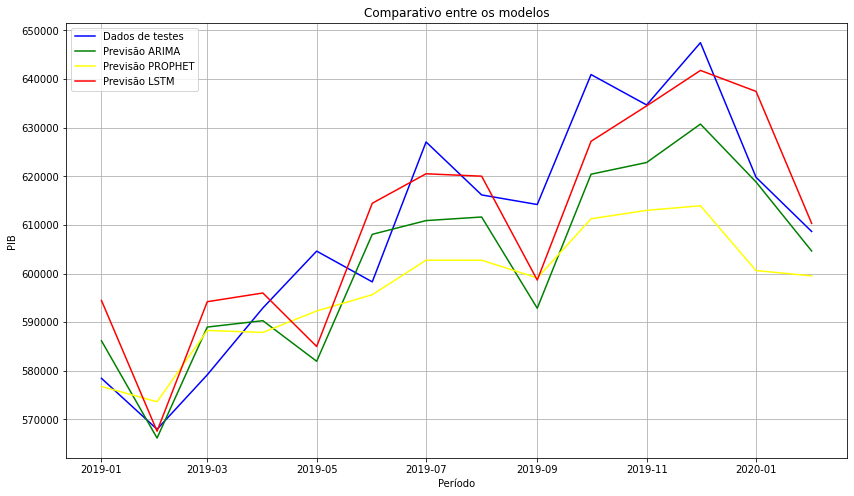

In [39]:
# Plotagem do comparativo entre os modelos
plt.figure(figsize=(14,8))
plt.plot(dfpib_comparativo.index, dfpib_comparativo["pib"], color='blue', label = 'Dados de testes')
plt.plot(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_ARIMA"], color = 'green', label = 'Previsão ARIMA')
plt.plot(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_PROPHET"], color = 'yellow', label = 'Previsão PROPHET')
plt.plot(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_LSTM"], color = 'red', label = 'Previsão LSTM')
plt.title('Comparativo entre os modelos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
#Comparativo dos erros

dfpib_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfpib_erro['MAE'] = [MAEARIMAPIB, MAELSTMPIB, MAEPROPHETPIB]
dfpib_erro['MSE'] = [MSEARIMAPIB, MSELSTMPIB, MSEPROPHETPIB]
dfpib_erro['RMSE'] = [RMSEARIMAPIB, RMSELSTMPIB, RMSEPROPHETPIB]
dfpib_erro = dfpib_erro.sort_values('MAE')
dfpib_erro.set_index('Modelos', inplace=True)
dfpib_erro.head()

,MAE,MSE,RMSE
Modelos,,,
LSTM,9654,140868984,11868
ARIMA,10744,169126237,13004
Prophet,14456,301714278,17369


## **MODELOS PREDITIVOS DAS IMPORTAÇÕES**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_arima = dfimp.iloc[:-14].copy()  
dfimp_test_arima =  dfimp.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modelARIMAIMP = auto_arima(dfimp_train_arima['imp'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12796.314, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12901.784, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12848.831, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12795.814, Time=0.47 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12861.988, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=12791.348, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12841.320, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=12789.909, Time=0.92 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12824.917, Time=0.72 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=12788.272, Time=3.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=12791.191, Time=1.89 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=12815.793, Time=1.95 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=12789.080, Time=4.08 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=12792.168, Time=1.47 sec
 ARIM

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modelARIMAIMP = auto_arima(dfimp_train_arima['imp'], test='adf', trace=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=13288.443, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13391.154, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13317.724, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13316.730, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13389.411, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=13298.393, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=13291.147, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=13288.373, Time=2.73 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=13292.278, Time=1.45 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=13286.798, Time=3.45 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=13286.860, Time=2.19 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=13313.486, Time=3.73 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=13293.535, Time=3.52 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=13272.349, Time=6.60 sec
 ARIM

In [ ]:
print(modelARIMAIMP.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(5, 1, 4)x(1, 0, [1], 12)   Log Likelihood               -6620.775
Date:                              Tue, 02 Mar 2021   AIC                          13267.551
Time:                                      18:04:37   BIC                          13315.656
Sample:                                           0   HQIC                         13286.805
                                              - 300                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.758e+07    2.1e-10   2.74e+17      0.000    5.76e+07    5.76e+07
ar.L1         -0.19

In [ ]:
# Treinamento do modelo
modelARIMAIMP.fit(dfimp_train_arima['imp'])

ARIMA(maxiter=50, method='lbfgs', order=(5, 1, 4), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
#Faz a predição 
forecast_arima = modelARIMAIMP.predict(n_periods=len(dfimp_test_arima['imp']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfimp_test_arima.index,columns=['Prediction'])
conf_int = modelARIMAIMP.predict(len(dfimp_test_arima['imp']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

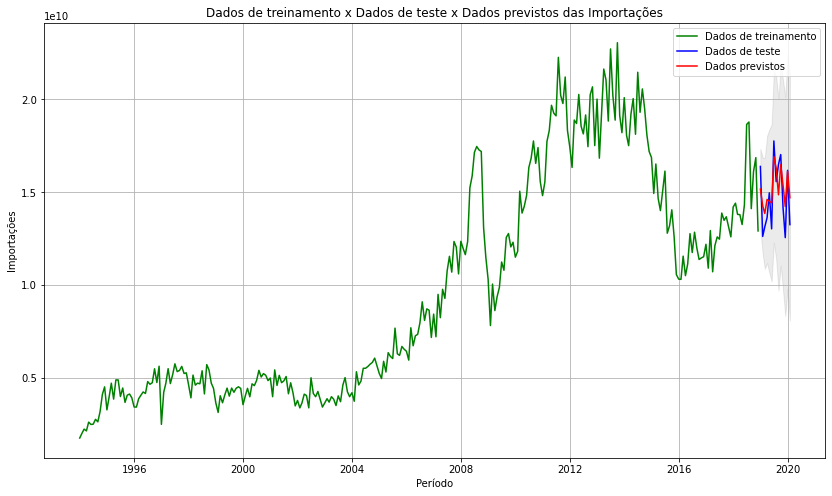

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_train_arima['imp'], color='green', label = 'Dados de treinamento')
plt.plot(dfimp_test_arima['imp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfimp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
plt.show()

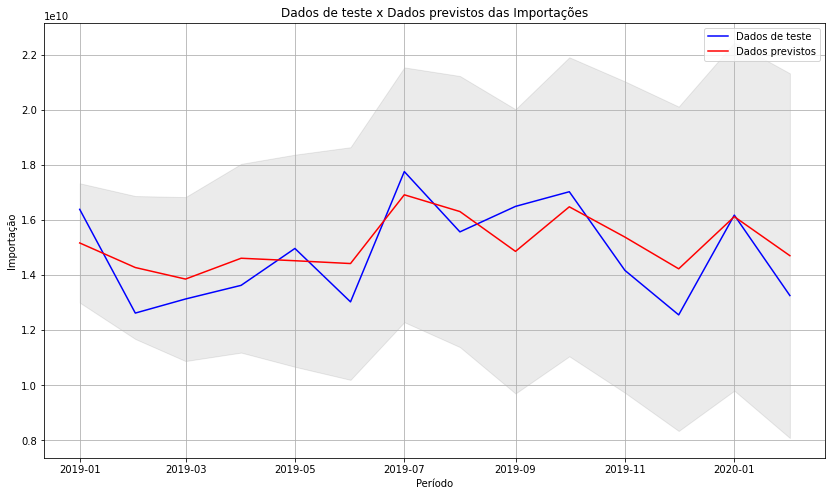

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_test_arima['imp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfimp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Importação')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAIMP = int(mean_absolute_error(dfimp_test_arima['imp'], forecast_arima['Prediction']))
MSEARIMAIMP = int(mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction']))
RMSEARIMAIMP = int(math.sqrt(mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction'])))


print('MSE: '+str(MSEARIMAIMP))
print('MAE: '+str(MAEARIMAIMP))
print('RMSE: '+str(RMSEARIMAIMP))

MSE: 1316782010634623232
MAE: 1040555745
RMSE: 1147511224


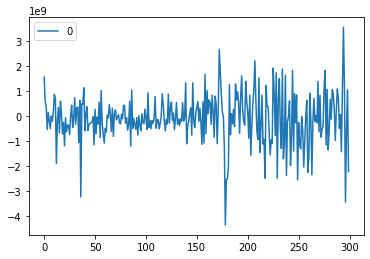

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(modelARIMAIMP.resid())
residuals.plot()

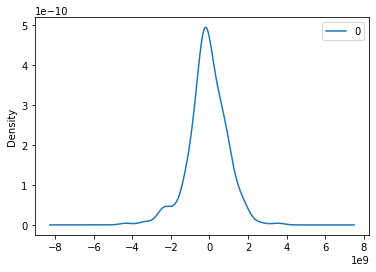

                  0
count  3.000000e+02
mean  -8.813462e+07
std    9.812911e+08
min   -4.336529e+09
25%   -5.534084e+08
50%   -1.221787e+08
75%    5.455803e+08
max    3.559495e+09


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_lstm = dfimp.iloc[:-14].copy()  
dfimp_test_lstm =  dfimp.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfimp_train_lstm.iloc[:,0:1].values
test_lstm = dfimp_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
288/288 [==============================] - 4s 10ms/step - loss: 0.0419
Epoch 2/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0057
Epoch 3/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0064
Epoch 4/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0067
Epoch 5/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0059
Epoch 6/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 7/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 8/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 9/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 10/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0038
Epoch 11/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0036
Epoch 12/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0044
E

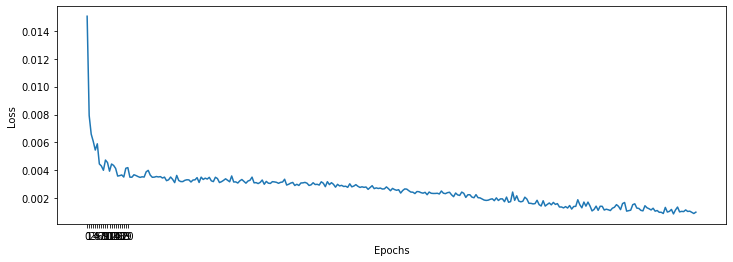

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

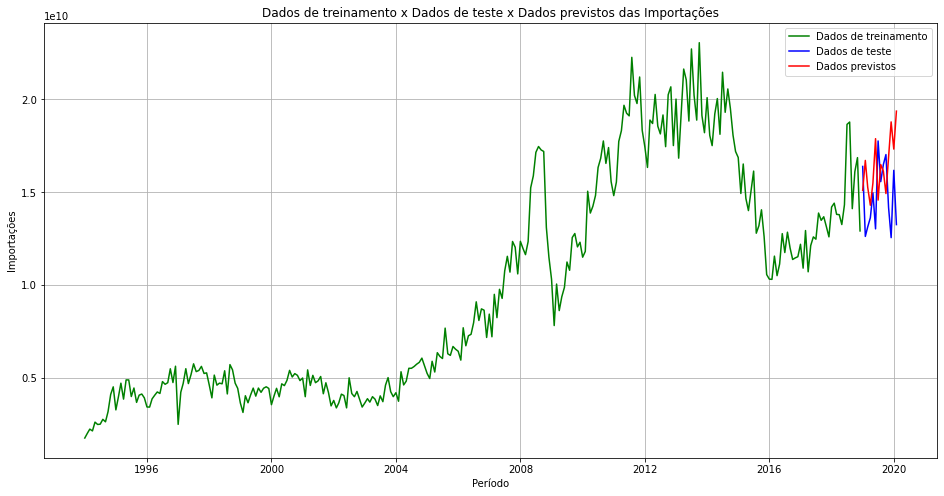

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfimp_train_lstm.index, dfimp_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfimp_test_lstm.index, dfimp_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfimp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
plt.show()

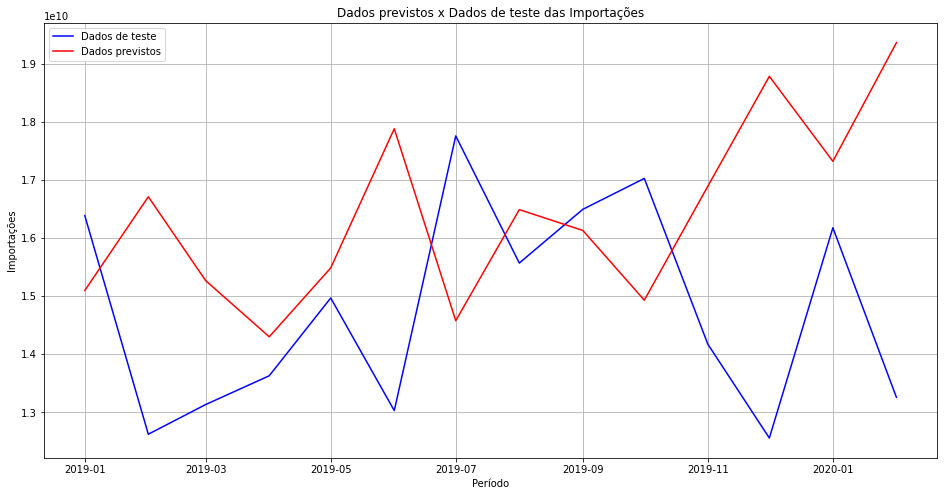

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfimp_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfimp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste das Importações')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMIMP = int(mean_absolute_error(dfimp_test_lstm,lstm_predictions))
MSELSTMIMP = int(mean_squared_error(dfimp_test_lstm,lstm_predictions))
RMSELSTMIMP = int(np.sqrt(mean_squared_error(dfimp_test_lstm,lstm_predictions)))

print('MSE: '+str(MSELSTMIMP))
print('MAE: '+str(MAELSTMIMP))
print('RMSE: '+str(RMSELSTMIMP))

MSE: 10540206886920364032
MAE: 2594552019
RMSE: 3246568478


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_prophet = dfimp.iloc[:-14].copy()  
dfimp_test_prophet =  dfimp.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfimp_train_prophet = pd.DataFrame({"ds": dfimp_train_prophet.index, "y": dfimp_train_prophet.imp})
dfimp_train_prophet.reset_index(drop = True, inplace = True)
dfimp_test_prophet = pd.DataFrame({"ds_test": dfimp_test_prophet.index, "y_test": dfimp_test_prophet.imp})
dfimp_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfimp_train_prophet.head()

,ds,y
0,1994-01-01,1768675231
1,1994-02-01,2030100974
2,1994-03-01,2248937491
3,1994-04-01,2151981505
4,1994-05-01,2624852192


In [ ]:
dfimp_test_prophet.head()

,ds_test,y_test
0,2019-01-01,16387829960
1,2019-02-01,12621762837
2,2019-03-01,13132998803
3,2019-04-01,13628618723
4,2019-05-01,14968051867


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet()
prophet_model.fit(dfimp_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(63.0, 0.5, 'Importações')

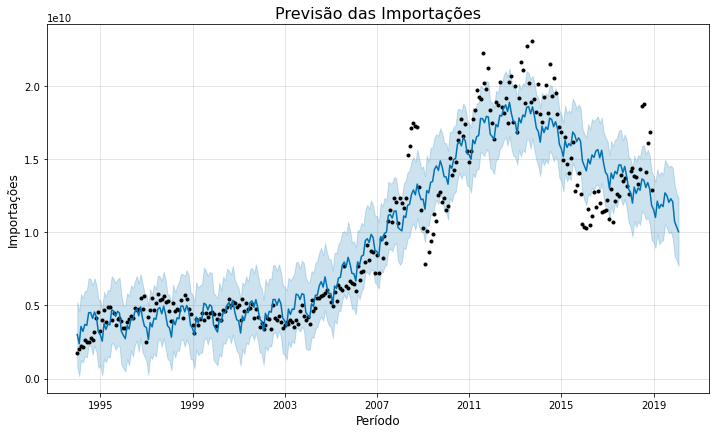

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão das Importações", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Importações", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,1.233547e+10,9.333295e+09,1.385180e+10,1.233547e+10,1.233547e+10,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,0.0,0.0,0.0,1.154095e+10
301,2019-02-01,1.224730e+10,8.925809e+09,1.342876e+10,1.224730e+10,1.224730e+10,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,0.0,0.0,0.0,1.100959e+10
302,2019-03-01,1.216767e+10,9.893455e+09,1.431296e+10,1.216727e+10,1.216767e+10,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,0.0,0.0,0.0,1.212391e+10
303,2019-04-01,1.207950e+10,9.179215e+09,1.384534e+10,1.207245e+10,1.208200e+10,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,0.0,0.0,0.0,1.163504e+10
304,2019-05-01,1.199418e+10,9.398628e+09,1.412780e+10,1.197731e+10,1.200126e+10,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,0.0,0.0,0.0,1.189846e+10


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfimp_test_prophet.set_index(dfimp_test_prophet['ds_test'], inplace=True) 
dfimp_train_prophet.set_index(dfimp_train_prophet['ds'], inplace=True) 

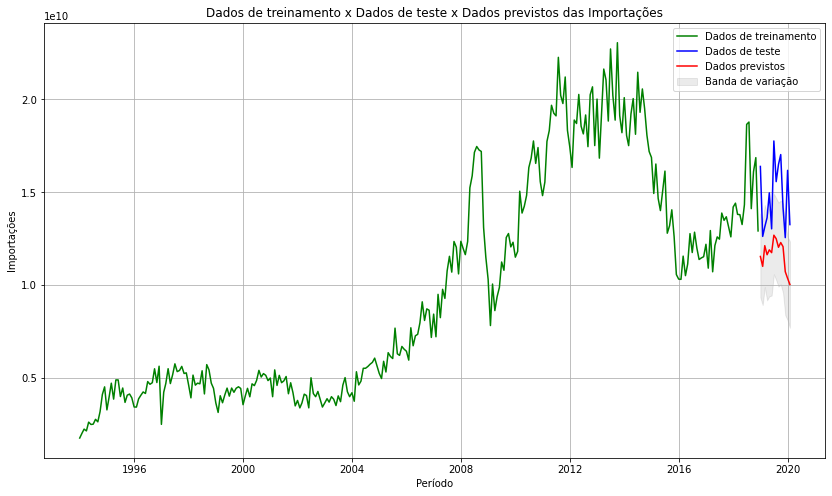

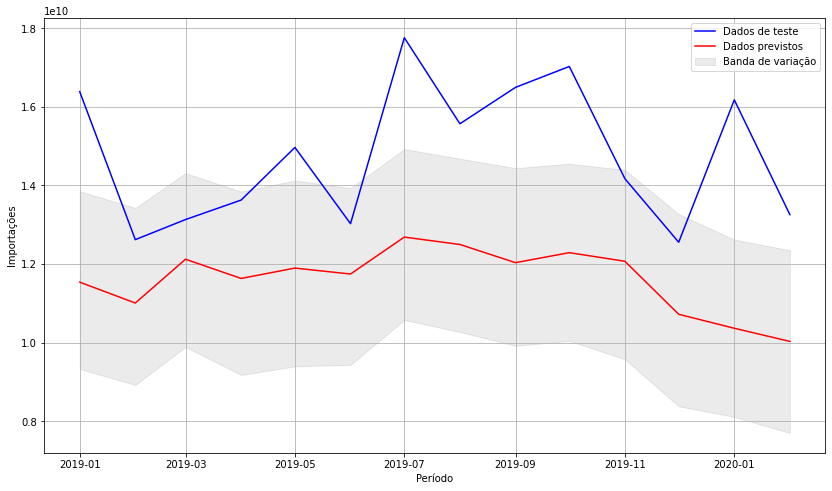

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfimp_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfimp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Importações")
plt.legend()
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfimp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Importações")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETIMP = int(mean_absolute_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETIMP = int(mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETIMP = int(np.sqrt(mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat'])))


print('MSE: '+str(MSEPROPHETIMP))
print('MAE: '+str(MAEPROPHETIMP))
print('RMSE: '+str(RMSEPROPHETIMP))

MSE: 12253513240758243328
MAE: 3151316933
RMSE: 3500501855


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfimp_comparativo = dfimp_test_arima.copy()
dfimp_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfimp_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfimp_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfimp_comparativo.head(14)

,imp,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,16387829960,1.516787e+10,1.154095e+10,1.509732e+10
2019-02-01,12621762837,1.427560e+10,1.100959e+10,1.671157e+10
2019-03-01,13132998803,1.385634e+10,1.212391e+10,1.526654e+10
2019-04-01,13628618723,1.461261e+10,1.163504e+10,1.429975e+10
2019-05-01,14968051867,1.452209e+10,1.189846e+10,1.548637e+10
2019-06-01,13028629358,1.442024e+10,1.174755e+10,1.788281e+10
2019-07-01,17759476963,1.691621e+10,1.268689e+10,1.457711e+10
2019-08-01,15569921736,1.630815e+10,1.249907e+10,1.648998e+10
2019-09-01,16495171374,1.486175e+10,1.203635e+10,1.613179e+10


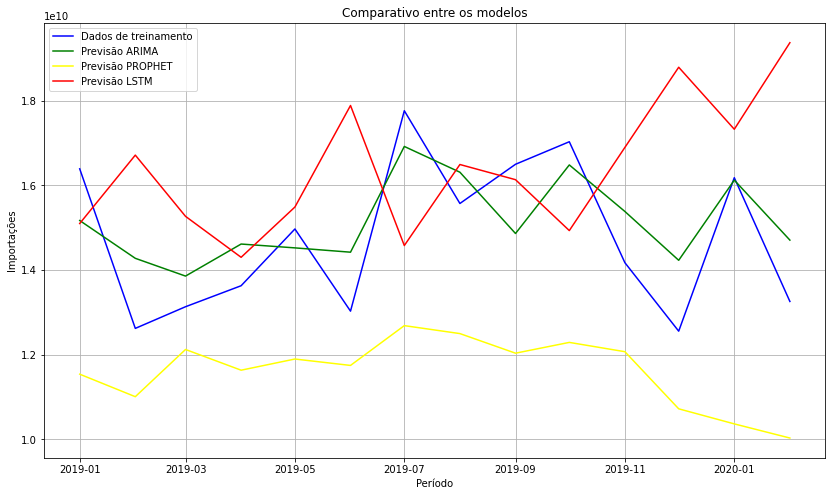

In [ ]:
# Plotagem do comparativo entre os modelos
plt.figure(figsize=(14,8))
plt.plot(dfimp_comparativo.index, dfimp_comparativo["imp"], color='blue', label = 'Dados de treinamento')
plt.plot(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_ARIMA"], color = 'green', label = 'Previsão ARIMA')
plt.plot(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_PROPHET"], color = 'yellow', label = 'Previsão PROPHET')
plt.plot(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_LSTM"], color = 'red', label = 'Previsão LSTM')
plt.title('Comparativo entre os modelos')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Comparativo dos erros
dfimp_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfimp_erro['MAE'] = [MAEARIMAIMP, MAELSTMIMP, MAEPROPHETIMP]
dfimp_erro['MSE'] = [MSEARIMAIMP, MSELSTMIMP, MSEPROPHETIMP]
dfimp_erro['RMSE'] = [RMSEARIMAIMP, RMSELSTMIMP, RMSEPROPHETIMP]
dfimp_erro = dfimp_erro.sort_values('MAE')
dfimp_erro.set_index('Modelos', inplace=True)
dfimp_erro.head()

,MAE,MSE,RMSE
Modelos,,,
ARIMA,1040555745,1316782010634623232,1147511224
LSTM,2594552019,10540206886920364032,3246568478
Prophet,3151316933,12253513240758243328,3500501855


## **MODELOS PREDITIVOS DAS EXPORTAÇÕES**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_arima = dfexp.iloc[:-14].copy()  
dfexp_test_arima =  dfexp.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modelARIMAEXP = auto_arima(dfexp_train_arima['exp'], test='adf', trace=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=13376.495, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13503.918, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13398.309, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13428.496, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13502.307, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=13428.270, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=13396.379, Time=0.59 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=13372.295, Time=4.61 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=13374.066, Time=4.25 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=13373.871, Time=6.32 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=13373.066, Time=5.43 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=13376.260, Time=2.09 sec
 ARIMA(3,1,2)(2,0,1)[12] intercept   : AIC=13358.930, Time=6.18 sec
 ARIMA(3,1,

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfexp_train_arima['exp'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12825.334, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12952.519, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12864.812, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12823.945, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12901.899, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=12824.697, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=12824.652, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12857.381, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=12826.652, Time=2.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=12857.581, Time=0.18 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=12826.513, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=12829.342, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=12828.394, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=12826.982, Time=0.41 sec

Best

In [ ]:
print(modelARIMAEXP.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  300
Model:             SARIMAX(5, 1, 4)x(1, 0, [1, 2], 12)   Log Likelihood               -6652.015
Date:                                 Tue, 02 Mar 2021   AIC                          13330.030
Time:                                         18:55:01   BIC                          13378.135
Sample:                                              0   HQIC                         13349.284
                                                 - 300                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.130      1.718      0.086      -0.031       0

In [ ]:
# Treinamento do modelo
modelARIMAEXP.fit(dfexp_train_arima['exp'])

ARIMA(maxiter=50, method='lbfgs', order=(5, 1, 4), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = modelARIMAEXP.predict(n_periods=len(dfexp_test_arima['exp']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfexp_test_arima.index,columns=['Prediction'])
conf_int = modelARIMAEXP.predict(len(dfexp_test_arima['exp']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

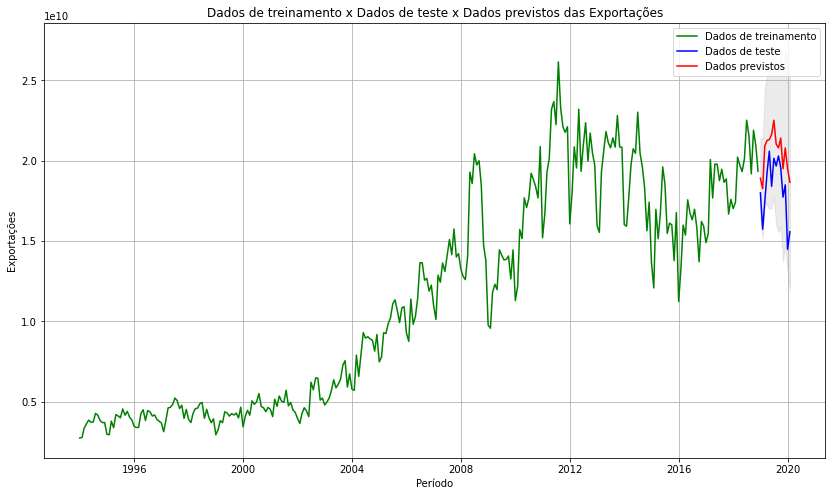

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_train_arima['exp'], color='green', label = 'Dados de treinamento')
plt.plot(dfexp_test_arima['exp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfexp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
plt.show()

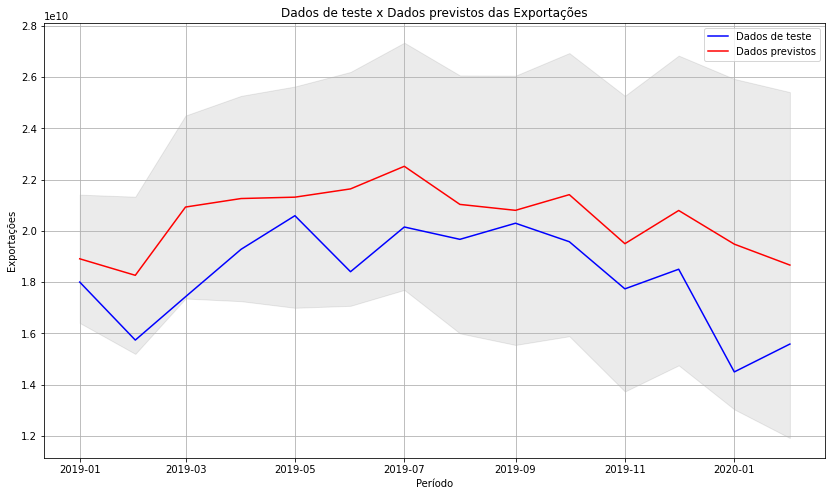

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_test_arima['exp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfexp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAEXP = int(mean_absolute_error(dfexp_test_arima['exp'], forecast_arima['Prediction']))
MSEARIMAEXP = int(mean_squared_error(dfexp_test_arima['exp'], forecast_arima['Prediction']))
RMSEARIMAEXP = int(math.sqrt(mean_squared_error(dfexp_test_arima['exp'], forecast_arima['Prediction'])))



print('MSE: '+str(MSEARIMAEXP))
print('MAE: '+str(MAEARIMAEXP))
print('RMSE: '+str(RMSEARIMAEXP))

MSE: 6300629551737437184
MAE: 2219464960
RMSE: 2510105486


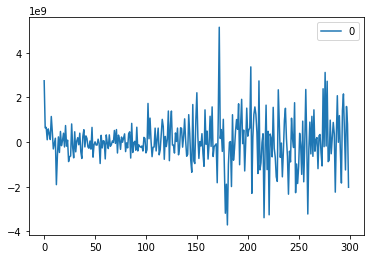

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(modelARIMAEXP.resid())
residuals.plot()

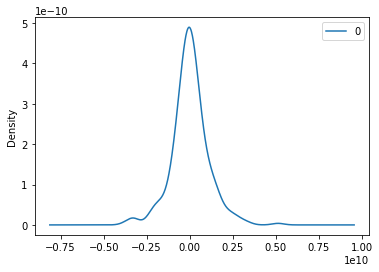

                  0
count  3.000000e+02
mean   3.191088e+07
std    1.073227e+09
min   -3.707042e+09
25%   -4.678949e+08
50%   -6.291056e+06
75%    5.262095e+08
max    5.144024e+09


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_lstm = dfexp.iloc[:-14].copy()  
dfexp_test_lstm =  dfexp.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfexp_train_lstm.iloc[:,0:1].values
test_lstm = dfexp_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
288/288 [==============================] - 4s 10ms/step - loss: 0.0419
Epoch 2/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0086
Epoch 3/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0086
Epoch 4/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0079
Epoch 5/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0068
Epoch 6/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0068
Epoch 7/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0054
Epoch 8/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0059
Epoch 9/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 10/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0055
Epoch 11/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0055
Epoch 12/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0046
E

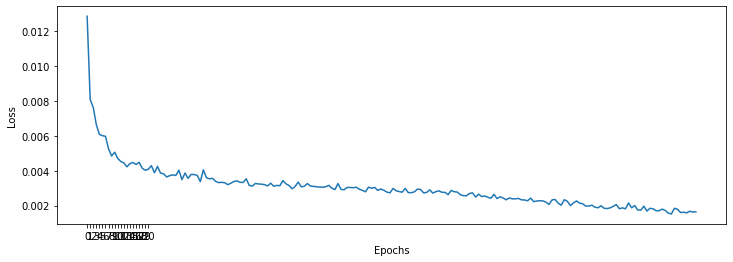

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

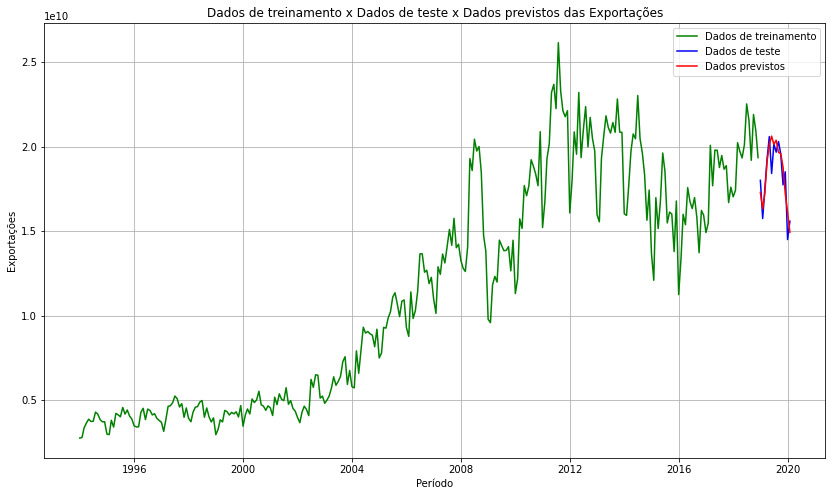

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.plot(dfexp_train_lstm.index, dfexp_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfexp_test_lstm.index, dfexp_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfexp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
plt.show()

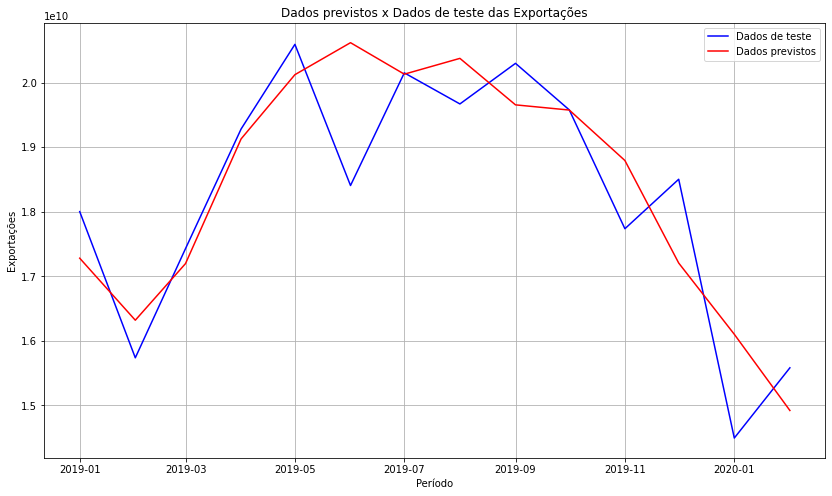

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(14,8))
plt.plot(dfexp_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfexp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste das Exportações')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMEXP = int(mean_absolute_error(dfexp_test_lstm,lstm_predictions))
MSELSTMEXP = int(mean_squared_error(dfexp_test_lstm,lstm_predictions))
RMSELSTMEXP = int(np.sqrt(mean_squared_error(dfexp_test_lstm,lstm_predictions)))


print('MSE: '+str(MSELSTMEXP))
print('MAE: '+str(MAELSTMEXP))
print('RMSE: '+str(RMSELSTMEXP))

MSE: 913217234196838016
MAE: 740353474
RMSE: 955624002


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_prophet = dfexp.iloc[:-14].copy()  
dfexp_test_prophet =  dfexp.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfexp_train_prophet = pd.DataFrame({"ds": dfexp_train_prophet.index, "y": dfexp_train_prophet.exp})
dfexp_train_prophet.reset_index(drop = True, inplace = True)
dfexp_test_prophet = pd.DataFrame({"ds_test": dfexp_test_prophet.index, "y_test": dfexp_test_prophet.exp})
dfexp_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfexp_train_prophet.head()

,ds,y
0,1994-01-01,2747187653
1,1994-02-01,2778288879
2,1994-03-01,3350391558
3,1994-04-01,3634841763
4,1994-05-01,3862059965


In [ ]:
dfexp_test_prophet.head(30)

,ds_test,y_test
0,2019-01-01,18001907016
1,2019-02-01,15737375000
2,2019-03-01,17428698480
3,2019-04-01,19281734438
4,2019-05-01,20592409187
5,2019-06-01,18406010533
6,2019-07-01,20150883169
7,2019-08-01,19669525248
8,2019-09-01,20298407777
9,2019-10-01,19576839231


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet()
prophet_model.fit(dfexp_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(63.0, 0.5, 'Exportações')

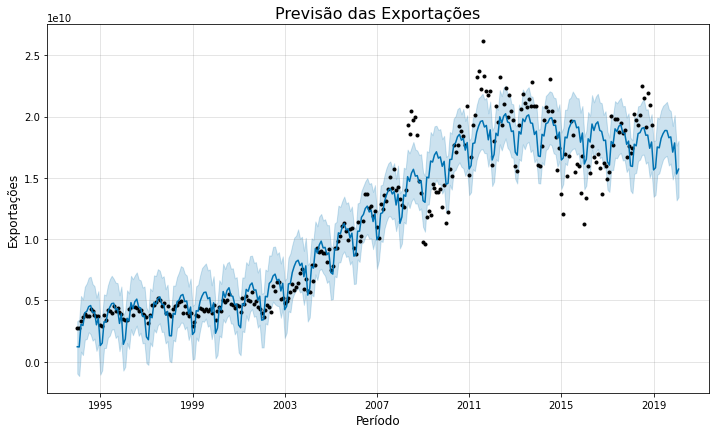

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão das Exportações", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Exportações", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,1.783700e+10,1.345871e+10,1.798843e+10,1.783700e+10,1.783700e+10,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,0.0,0.0,0.0,1.565085e+10
301,2019-02-01,1.781984e+10,1.361436e+10,1.806912e+10,1.781984e+10,1.781984e+10,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,0.0,0.0,0.0,1.581952e+10
302,2019-03-01,1.780435e+10,1.525101e+10,1.991112e+10,1.780255e+10,1.780492e+10,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,0.0,0.0,0.0,1.751780e+10
303,2019-04-01,1.778720e+10,1.536992e+10,1.982420e+10,1.778140e+10,1.779160e+10,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,0.0,0.0,0.0,1.744671e+10
304,2019-05-01,1.777060e+10,1.596181e+10,2.050405e+10,1.775919e+10,1.778224e+10,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,0.0,0.0,0.0,1.821720e+10


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfexp_test_prophet.set_index(dfexp_test_prophet['ds_test'], inplace=True) 
dfexp_train_prophet.set_index(dfexp_train_prophet['ds'], inplace=True) 

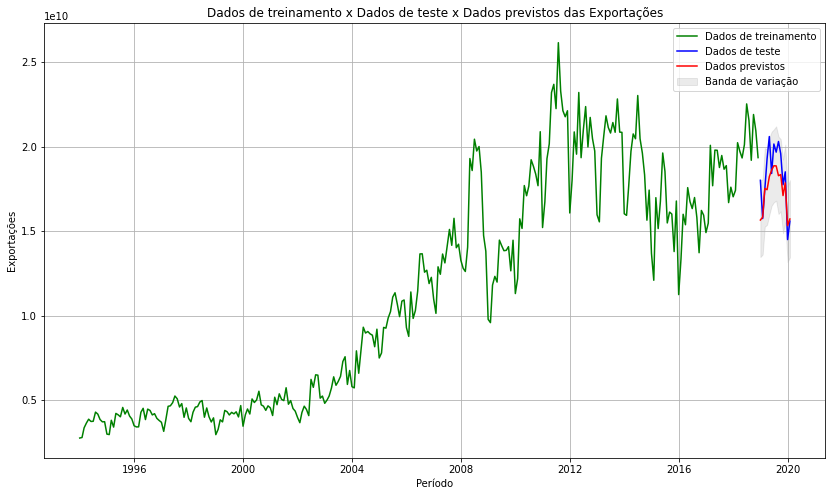

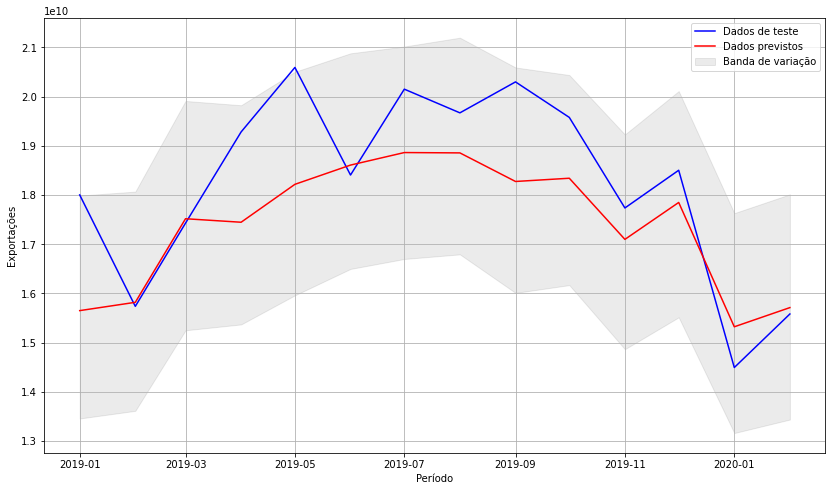

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfexp_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfexp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Exportações")
plt.legend()
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfexp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Exportações")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETEXP = int(mean_absolute_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETEXP = int(mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETEXP = int(np.sqrt(mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat'])))


print('MSE: '+str(MSEPROPHETEXP))
print('MAE: '+str(MAEPROPHETEXP))
print('RMSE: '+str(RMSEPROPHETEXP))

MSE: 1719510691019043328
MAE: 1039005659
RMSE: 1311301144


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfexp_comparativo = dfexp_test_arima.copy()
dfexp_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfexp_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfexp_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfexp_comparativo.head(14)

,exp,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,18001907016,1.891031e+10,1.565085e+10,1.728035e+10
2019-02-01,15737375000,1.826528e+10,1.581952e+10,1.631967e+10
2019-03-01,17428698480,2.092995e+10,1.751780e+10,1.719682e+10
2019-04-01,19281734438,2.126230e+10,1.744671e+10,1.912839e+10
2019-05-01,20592409187,2.131578e+10,1.821720e+10,2.012290e+10
2019-06-01,18406010533,2.163797e+10,1.860807e+10,2.061829e+10
2019-07-01,20150883169,2.252018e+10,1.886270e+10,2.013068e+10
2019-08-01,19669525248,2.103292e+10,1.885575e+10,2.037536e+10
2019-09-01,20298407777,2.080163e+10,1.827496e+10,1.965532e+10


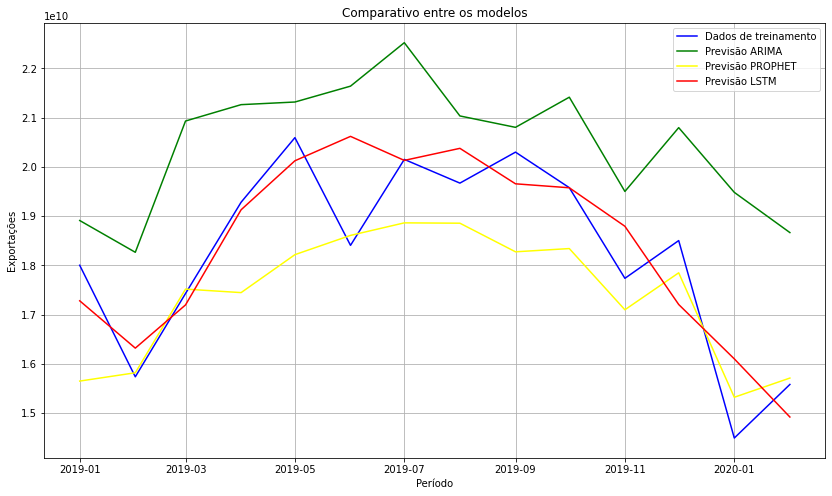

In [ ]:
# Plotagem do comparativo entre os modelos
plt.figure(figsize=(14,8))
plt.plot(dfexp_comparativo.index, dfexp_comparativo["exp"], color='blue', label = 'Dados de treinamento')
plt.plot(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_ARIMA"], color = 'green', label = 'Previsão ARIMA')
plt.plot(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_PROPHET"], color = 'yellow', label = 'Previsão PROPHET')
plt.plot(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_LSTM"], color = 'red', label = 'Previsão LSTM')
plt.title('Comparativo entre os modelos')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Comparativo dos erros
dfexp_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfexp_erro['MAE'] = [MAEARIMAEXP, MAELSTMEXP, MAEPROPHETEXP]
dfexp_erro['MSE'] = [MSEARIMAEXP, MSELSTMEXP, MSEPROPHETEXP]
dfexp_erro['RMSE'] = [RMSEARIMAEXP, RMSELSTMEXP, RMSEPROPHETEXP]
dfexp_erro = dfexp_erro.sort_values('MAE')
dfexp_erro.set_index('Modelos', inplace=True)
dfexp_erro.head()

,MAE,MSE,RMSE
Modelos,,,
LSTM,740353474,913217234196838016,955624002
Prophet,1039005659,1719510691019043328,1311301144
ARIMA,2219464960,6300629551737437184,2510105486
